# Figure 2

In [ ]:
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cmocean.cm as cmo

import ppe_plot as ppeplot
import ppe_load as ppeload
import ppe_analyze as ppealyz

%load_ext watermark
%watermark -iv

sys       : 3.11.6 | packaged by conda-forge | (main, Oct  3 2023, 10:40:35) [GCC 12.3.0]
cmocean   : 3.0.3
numpy     : 1.24.4
xarray    : 2023.10.1
matplotlib: 3.8.0
cartopy   : 0.22.0



In [3]:
# Get plotting settings
ppeplot.setup_plotting_workspace()

## Load model output

In [4]:
# Get area weights
cesm_weights = xr.open_dataset("/glade/work/bbuchovecky/PPE_analysis/weights/COUP_PPE_weights_atmgrid.nc").rename({"globweights": "globalweights"})
assert cesm_weights.landweights.sum(dim=["lat", "lon"]) == 1

hadcm_weights = xr.open_dataset('/glade/work/bbuchovecky/HadCM3_analysis/weights/HadCM3_weights_v2.nc')
assert hadcm_weights.landweights.sum(dim=["lat", "lon"]) == 1

# Identify variables to load
varlist = ["SWCF", "ET", "U_10m", "T_S"]

# Load time-mean variables
cesm_ppe, cesm_std = ppeload.get_cesm(varlist+["CLDLOW"], "time_mean")
hadhst_ppe, hadhst_std = ppeload.get_hadcm(varlist, "control", "time_mean")
hada1b_ppe, hada1b_std = ppeload.get_hadcm(varlist, "a1b", "time_mean")

# Compute the delta (perturbed - control)
cesm_delta = dict()
hadhst_delta = dict()
hada1b_delta = dict()

for v in varlist:
    cesm_delta[v] = cesm_ppe[v] - cesm_std[v]
    hadhst_delta[v] = hadhst_ppe[v] - hadhst_std[v]
    hada1b_delta[v] = hada1b_ppe[v] - hada1b_std[v]

v = "CLDLOW"
cesm_delta[v] = cesm_ppe[v] - cesm_std[v]

# Compute the land and ocean mean
cesm_delta_areamean = dict()
hadhst_delta_areamean = dict()
hada1b_delta_areamean = dict()

for w, weight in zip(["lm", "om"], ["landweights", "oceanweights"]):
    try:
        cesm_delta_areamean[w];
        hadhst_delta_areamean[w];
        hada1b_delta_areamean[w];
    except KeyError:
        cesm_delta_areamean[w] = dict()
        hadhst_delta_areamean[w] = dict()
        hada1b_delta_areamean[w] = dict()

    assert np.round(cesm_weights[weight].sum(), 3) == 1.
    assert np.round(hadcm_weights[weight].sum(), 3) == 1.

    for v in varlist:
        cesm_delta_areamean[w][v] = cesm_delta[v].weighted(cesm_weights[weight]).mean(dim=["lat", "lon"])
        hadhst_delta_areamean[w][v] = hadhst_delta[v].weighted(hadcm_weights[weight]).mean(dim=["lat", "lon"])
        hada1b_delta_areamean[w][v] = hada1b_delta[v].weighted(hadcm_weights[weight]).mean(dim=["lat", "lon"])
    
    v = "CLDLOW"
    cesm_delta_areamean[w][v] = cesm_delta[v].weighted(cesm_weights[weight]).mean(dim=["lat", "lon"])

CESM2 time_mean:
  SWCF
  ET
  U_10m
  T_S
  CLDLOW
HadCM3 control time_mean:
  SWCF
  ET
  U_10m
  T_S
HadCM3 a1b time_mean:
  SWCF
  ET
  U_10m
  T_S


## Create the slope maps

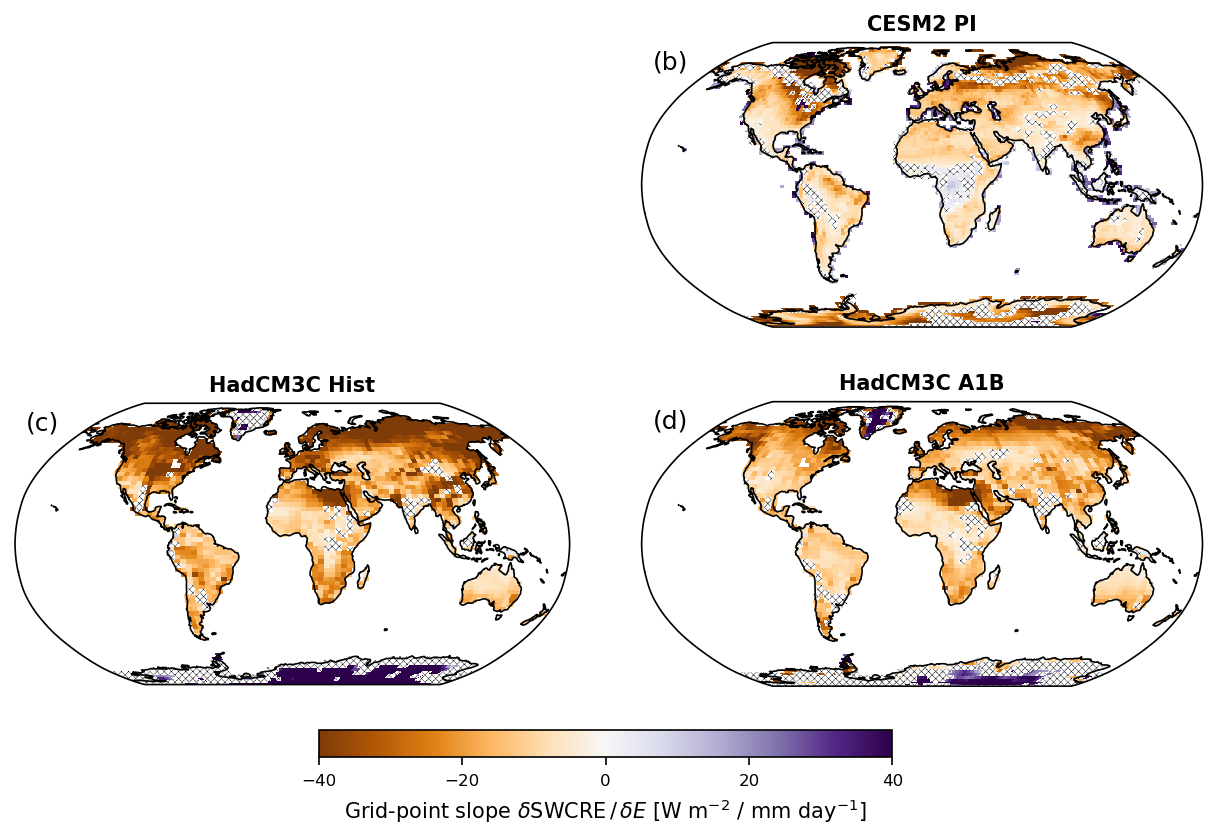

In [ ]:
xvar = 'ET'
yvar = 'SWCF'

# Create figure and axes
fig, axes = plt.subplots(
    3, 4, figsize=(8, 5.5),
    height_ratios=[1,1,0.08],
    layout='constrained',
)

## Define axes
gs = axes[0,0].get_gridspec()
for a in axes.flatten(): a.remove()
ax = [
    None,
    fig.add_subplot(gs[0, 2:4], projection=ccrs.Robinson()),
    fig.add_subplot(gs[1, 0:2], projection=ccrs.Robinson()),
    fig.add_subplot(gs[1, 2:4], projection=ccrs.Robinson()),
]
axcb = fig.add_subplot(gs[2, 1:3])

## Parameters for SWCF / ET slope
vabs = 40
cmap = 'PuOr'

cf1 = ppeplot.plot_slope_map(ax[1], cesm_delta[xvar], cesm_delta[yvar], ppealyz.ols_field, alpha_fdr=0.05, cmap=cmap, vmin=-vabs, vmax=vabs, mask_ocean=cesm_weights["landweights"])
cf2 = ppeplot.plot_slope_map(ax[2], hadhst_delta[xvar], hadhst_delta[yvar], ppealyz.ols_field, alpha_fdr=0.05, cmap=cmap, vmin=-vabs, vmax=vabs, mask_ocean=hadcm_weights["landweights"])
cf3 = ppeplot.plot_slope_map(ax[3], hada1b_delta[xvar], hada1b_delta[yvar], ppealyz.ols_field, alpha_fdr=0.05, cmap=cmap, vmin=-vabs, vmax=vabs, mask_ocean=hadcm_weights["landweights"])

ax[1].set_title(ppeplot.label_dict["cesm"], fontsize=10, fontweight='bold')
ax[2].set_title(ppeplot.label_dict["hadhst"], fontsize=10, fontweight='bold')
ax[3].set_title(ppeplot.label_dict["hada1b"], fontsize=10, fontweight='bold')

cb = fig.colorbar(cf1, cax=axcb, fraction=0.0225, orientation='horizontal')
cb.ax.tick_params(labelsize=8)
cb.set_ticks([-40, -20, 0, 20, 40])
cb.set_label('Grid-point slope $\delta \\text{SWCRE} \\, / \\, \delta E$ [W m$^{-2}$ / mm day$^{-1}$]', fontsize=10)

## Add subplot numbering
for a, letter in zip(ax[1:4], ppeplot.figenum[1:4]):
    a.text(
        0.02, 0.975, f'({letter})',
        fontsize=12,
        fontweight='regular',
        ha='left', va='top',
        transform=a.transAxes)

## Save figure
fig.savefig('../figures/main/fig2_maps.pdf', bbox_inches='tight')

## Create the scatter plot

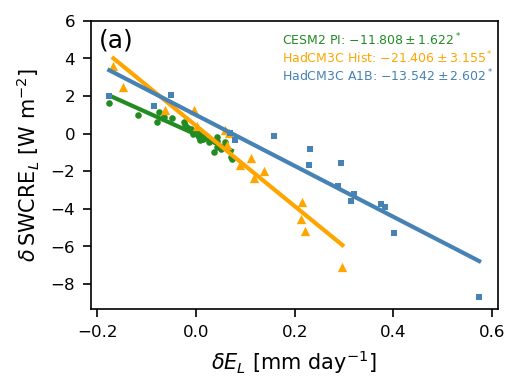

In [ ]:
xvar = 'ET'
yvar = 'SWCF'

fig, ax = plt.subplots(figsize=(3.5,2.5))
these_stats = dict(hadhst=dict(), hada1b=dict(), cesm=dict(), cmip=dict())
sm = "lm"

key = "cesm"
x = cesm_delta_areamean[sm][xvar]
y = cesm_delta_areamean[sm][yvar]
these_stats[key][yvar] = ppeplot.plot_scatter_regression(ax, x, y, ppealyz.ols_single, key, do_print=True)

key = "hadhst"
x = hadhst_delta_areamean[sm][xvar]
y = hadhst_delta_areamean[sm][yvar]
these_stats[key][yvar] = ppeplot.plot_scatter_regression(ax, x, y, ppealyz.ols_single, key, do_print=True)

key = "hada1b"
x = hada1b_delta_areamean[sm][xvar]
y = hada1b_delta_areamean[sm][yvar]
these_stats[key][yvar] = ppeplot.plot_scatter_regression(ax, x, y, ppealyz.ols_single, key, do_print=True)

## Add description of fit statistics to each subplot
def format_label_text(this_stats, key, alpha=0.05):
    ast = ""
    if this_stats["slope_p_value"] < alpha:
        ast = "^*"
    this_label = f"{ppeplot.label_dict[key]}: ${this_stats['slope']: 0.3f} \\pm {this_stats['slope_ci_halfwidth']: 0.3f}{ast}$"
    return this_label

stats_xpos = 0.47
stats_ypos = 0.775
stats_width = 0.46
stats_height = 0.25

for j, key in enumerate(["cesm", "hadhst", "hada1b"]):
    ax.text(
        stats_xpos, stats_ypos+(3-j)*(stats_height/4),
        format_label_text(these_stats[key]["SWCF"], key, alpha=0.05),
        fontsize=6, color=ppeplot.c_dict[key],
        ha='left', va='top',
        transform=ax.transAxes
    )

## Set axis labels
ax.set_xlabel('$\delta E_L$ [mm day$^{-1}$]', fontsize=10)
ax.set_ylabel('$\delta \\, \\text{SWCRE}_L$ [W m$^{-2}$]', fontsize=10)

ax.set_ylim(None, 6)

ax.text(
    0.02, 0.975, f'(a)',
    fontsize=12,
    fontweight='regular',
    ha='left', va='top',
    transform=ax.transAxes)

## Save figure
fig.savefig('../figures/main/fig2_scatter.pdf', bbox_inches='tight')